## Frozen Lake with Q-Learning

### Setup

First step: find course helpers library and update `sys.path` to find it.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys, subprocess

repo_url = "https://github.com/anton-dergunov/hugging-face-deep-rl.git"
target_dir = "hugging-face-deep-rl"
local_src = os.path.abspath("../src")

if os.path.isdir(local_src):
    repo_root = os.path.abspath("..")
    print("✅ Using local source for course helpers")
else:
    if not os.path.exists(target_dir):
        subprocess.run(["git", "clone", repo_url, target_dir], check=True)
    repo_root = os.path.abspath(target_dir)
    print("✅ Cloned repo with course helpers")

src_path = os.path.join(repo_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

print(f"🔧 sys.path updated with: {src_path}")

✅ Using local source for course helpers
🔧 sys.path updated with: /Users/anton/Dropbox/src/hugging-face-deep-rl/src


In [3]:
from rlcourse.system_setup import setup_env
setup_env()

🔧 Bootstrapping environment...
✅ swig already installed
📦 Packages installed
🔇 Warnings filtered
✅ Environment ready


In [ ]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import gymnasium as gym
from IPython.display import Video
import matplotlib.pyplot as plt

from rlcourse import gymnasium_utils

In [ ]:
VIDEO_BASE_PATH = f"videos/qlearning_"

os.makedirs(os.path.dirname(VIDEO_BASE_PATH), exist_ok=True)

### Environment

[Frozen lake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/): the task is to cross the lake from start (position [0,0] on the 2D grid) to the goal (last row, last column) without falling into any holes.

Some of the parameters of the environment:
- `map_name`: "4x4" or "8x8", loads a predefined map of the corresponding size
- `desc`: specfies custom map
- `is_slippery`: if true, then the player may "slip" and not always move in the indended direction

**Action space**: a number in the range `{0, 3}`:
- 0: move left
- 1: move down
- 2: move right
- 3: move up

**Observation space**: a value representing the player's current position as `current_row * ncols + current_col`.

**Rewards**:
- +1 for reaching the goal
- 0 for reaching a hole or a frozen cell

**Episode ends when**:
- Player moves into a hole
- Player reahes the goal
- Length of the episode is 100 (for "4x4" map) or 200 (for "8x8" map)

In [6]:
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False, render_mode="rgb_array")

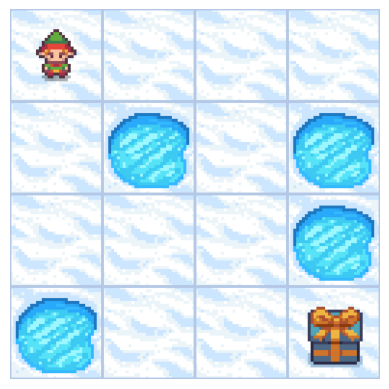

In [7]:
gymnasium_utils.show_environment(env)

In [8]:
gymnasium_utils.describe_environment(env)

Observation Space:
  Discrete(n=16)
  Example observation: 8

Action Space:
  Discrete(n=4)
  Example action: 3

Max episode steps: 100


### Q-Learning

Involves training Q-Function $Q(s,a)$ of a state $s$ and action $a$ in that state. It is encoded by a Q-Table.

**Hyperparameters**:
- $\alpha$ — learning rate (e.g. $0.1$)  
- $\gamma$ — discount factor (e.g. $0.99$)  
- $\epsilon$ — exploration probability for $\epsilon$-greedy (or use $\epsilon$-decay)

**Algorithm**:

1. Initialize $Q(s,a)$ arbitrarily for all states $s$ and actions $a$ (e.g. zeros).
2. For each episode:
   1. Initialize starting state $s$.
   2. Repeat until $s$ is terminal:
      - Choose action $a$ from $s$ using an $\epsilon$-greedy policy derived from $Q$.
      - Take action $a$, observe reward $r$ and next state $s'$.
      - Update:
        $$
        Q(s, a) \leftarrow Q(s, a) + \alpha\Big(r + \gamma \max_{a'} Q(s', a') - Q(s, a)\Big)
        $$
      - Set $s \leftarrow s'$.

In [9]:
def init_q_table(env):
    state_space = env.observation_space.n
    action_space = env.action_space.n
    q_table = np.zeros((state_space, action_space))
    return q_table

In [10]:
def greedy_policy(q_table, state):
    return np.argmax(q_table[state])

def epsilon_greedy_policy(q_table, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(q_table.shape[1])
    else:
        return greedy_policy(q_table, state)

In [11]:
def epsilon_schedule(eps_start, eps_end, eps_decay, episode):
    return eps_end + (eps_start - eps_end) * np.exp(-eps_decay * episode)

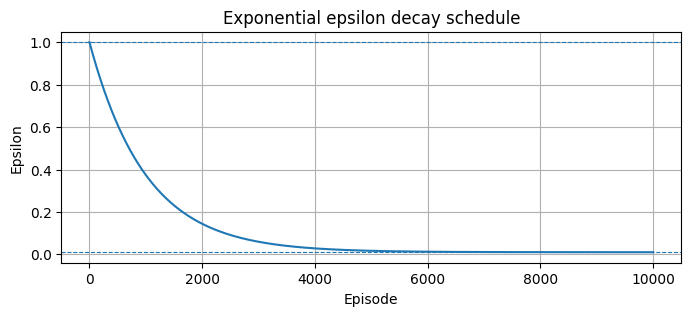

In [12]:
def plot_epsilon_schedule(eps_start, eps_end, eps_decay, n_episodes=1000, show_half_life=True):
    eps = epsilon_schedule(eps_start, eps_end, eps_decay, np.arange(n_episodes))

    _, ax = plt.subplots(figsize=(8, 3))
    ax.plot(np.arange(n_episodes), eps)
    ax.axhline(eps_start, linestyle='--', linewidth=0.8)
    ax.axhline(eps_end, linestyle='--', linewidth=0.8)
    ax.set_xlabel("Episode")
    ax.set_ylabel("Epsilon")
    ax.set_title("Exponential epsilon decay schedule")
    ax.grid(True)

plot_epsilon_schedule(
    n_episodes = 10_000,
    eps_start = 1.0,
    eps_end = 0.01,
    eps_decay = 0.001)

In [13]:
def q_learning(env, n_episodes, eps_start, eps_end, eps_decay, max_steps, lr, gamma, success_fn=None):
    q_table = init_q_table(env)
    rewards = []
    lengths = []
    successes = []

    for episode in tqdm(range(n_episodes)):
        eps = epsilon_schedule(eps_start, eps_end, eps_decay, episode)

        state, _ = env.reset()
        ep_reward = 0
        ep_length = 0
        ep_success = False

        for _ in range(max_steps):
            # Choose action using epsilon-greedy policy
            action = epsilon_greedy_policy(q_table, state, eps)

            # Take the action, observe reward and next state
            new_state, reward, terminated, truncated, info = env.step(action)
            ep_reward += reward
            ep_length += 1
            if success_fn and success_fn(reward, terminated, truncated, info):
                ep_success = True

            # Update Q-table Q(s,a)
            q_table[state, action] = q_table[state, action] + \
                lr * (reward + gamma * np.max(q_table[new_state]) - q_table[state, action])

            if terminated or truncated:
                break

            state = new_state

        rewards.append(ep_reward)
        lengths.append(ep_length)
        successes.append(1 if ep_success else 0)

    diagnostics = {"rewards": rewards, "lengths": lengths, "successes": successes}
    return q_table, diagnostics

In [14]:
class QLearningAgent:
    def __init__(self, q_table):
        self.q_table = q_table

    def predict(self, obs, deterministic=True,  **kwargs):
        # TODO Handle deterministic
        actions = np.argmax(self.q_table[obs], axis=-1)
        return actions, None

In [71]:
def moving_average(x, window):
    if window <= 1:
        return np.asarray(x, dtype=float)
    return np.convolve(x, np.ones(window)/window, mode='valid')

def plot_diagnostics(diagnostics, window=100, show_ci=True, figsize=(10,5)):
    rewards = np.asarray(diagnostics.get("rewards", []), dtype=float)
    successes = np.asarray(diagnostics.get("successes", []), dtype=float)
    lengths = np.asarray(diagnostics.get("lengths", []), dtype=float)

    _, axes = plt.subplots(3, 1, figsize=figsize, sharex=True,
                           gridspec_kw={"height_ratios": [3, 1, 1]})
    ax = axes[0]
    ax.set_title(f"Moving average metrics (window={window})")
    if rewards.size:
        ma = moving_average(rewards, window)
        ax.plot(np.arange(len(ma)), ma)
        if show_ci:
            # approximate CI using rolling std (not perfect but informative)
            # compute rolling std via convolution trick:
            pad = window - 1
            means = np.convolve(rewards, np.ones(window), mode='valid') / window
            sq = rewards**2
            means_sq = np.convolve(sq, np.ones(window), mode='valid') / window
            std = np.sqrt(np.maximum(0.0, means_sq - means**2))
            sem = std / np.sqrt(window)
            ax.fill_between(np.arange(len(means)), means - 1.96 * sem, means + 1.96 * sem, alpha=0.2)
    ax.set_ylabel("Reward")
    ax.grid(True)

    ax2 = axes[1]
    if successes.size:
        ma_s = moving_average(successes, window)
        ax2.plot(np.arange(len(ma_s)), ma_s)
    ax2.set_ylabel("Success")
    ax2.grid(True)

    ax3 = axes[2]
    if lengths.size:
        ma_l = moving_average(lengths, window)
        ax3.plot(np.arange(len(ma_l)), ma_l)
    ax3.set_xlabel("Episode")
    ax3.set_ylabel("Length")
    ax3.grid(True)
    plt.tight_layout()

    plt.show()

In [75]:
def run_experiment(exp_id, env_id, env_kwargs, learning_kwards, success_fn):
    env = gym.make(env_id, **env_kwargs, render_mode="rgb_array")

    q_table, diagnostics = q_learning(
        env,
        success_fn = success_fn,
        **learning_kwards)

    plot_diagnostics(diagnostics)

    model = QLearningAgent(q_table)
    eval_result = gymnasium_utils.stable_evaluate(model, env_id, env_kwargs=env_kwargs)
    display(pd.DataFrame([eval_result]).style.hide(axis="index"))

    video_path = VIDEO_BASE_PATH + exp_id + ".mp4"
    gymnasium_utils.record_agent_video(model, env_id, env_kwargs=env_kwargs, video_path=video_path, steps=100)

    display(Video(video_path, embed=True))

### Frozen Lake: 4x4 non-slippery

  0%|          | 0/10000 [00:00<?, ?it/s]

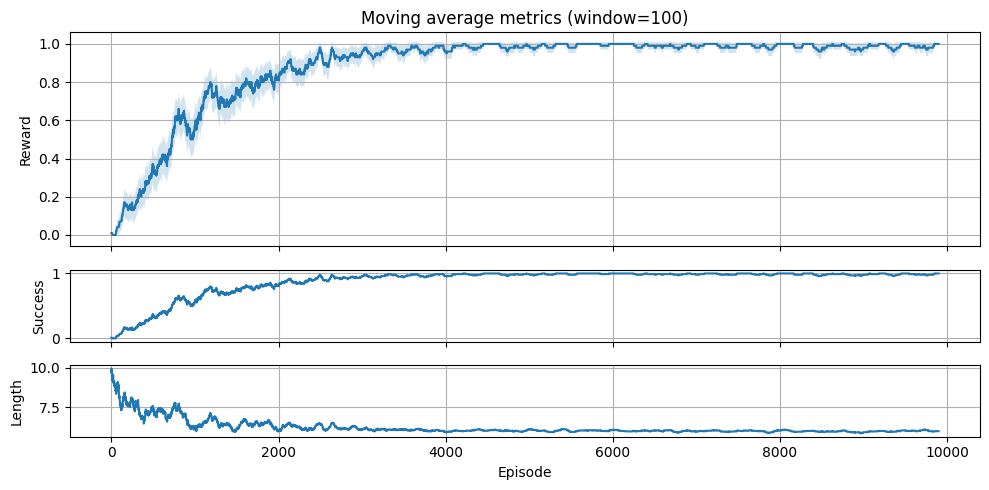

mean_reward,std_reward,ci_low,ci_high,n_total
1.000000,0.000000,1.000000,1.000000,90


Saved video to videos/qlearning_frozen_lake_4x4_non_slippery.mp4


In [77]:
run_experiment(
    exp_id="frozen_lake_4x4_non_slippery",
    env_id="FrozenLake-v1",
    env_kwargs={
        "map_name": "4x4",
        "is_slippery": False,
    },
    learning_kwards={
        "n_episodes": 10_000,
        "eps_start": 1.0,
        "eps_end": 0.01,
        "eps_decay": 0.001,
        "max_steps": 100,
        "lr": 0.7,
        "gamma": 0.95,
    },
    success_fn=lambda reward, terminated, truncated, info: reward > 0,
)

### Frozen Lake: 4x4 slippery

  0%|          | 0/10000 [00:00<?, ?it/s]

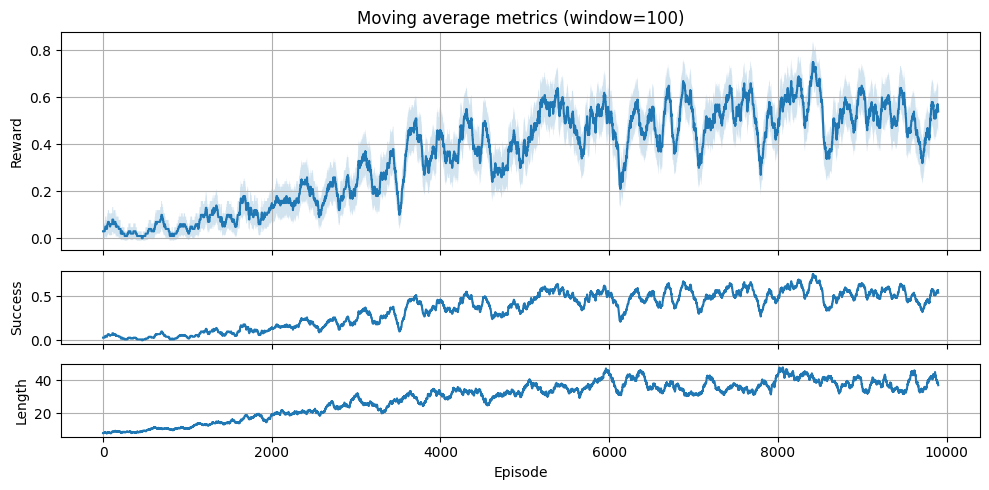

mean_reward,std_reward,ci_low,ci_high,n_total
0.711111,0.436315,0.620968,0.801255,90


Saved video to videos/qlearning_frozen_lake_4x4_slippery.mp4


In [78]:
run_experiment(
    exp_id="frozen_lake_4x4_slippery",
    env_id="FrozenLake-v1",
    env_kwargs={
        "map_name": "4x4",
        "is_slippery": True,
    },
    learning_kwards={
        "n_episodes": 10_000,
        "eps_start": 1.0,
        "eps_end": 0.01,
        "eps_decay": 0.001,
        "max_steps": 100,
        "lr": 0.7,
        "gamma": 0.95,
    },
    success_fn=lambda reward, terminated, truncated, info: reward > 0,
)

### Frozen Lake: 8x8 non-slippery

  0%|          | 0/10000 [00:00<?, ?it/s]

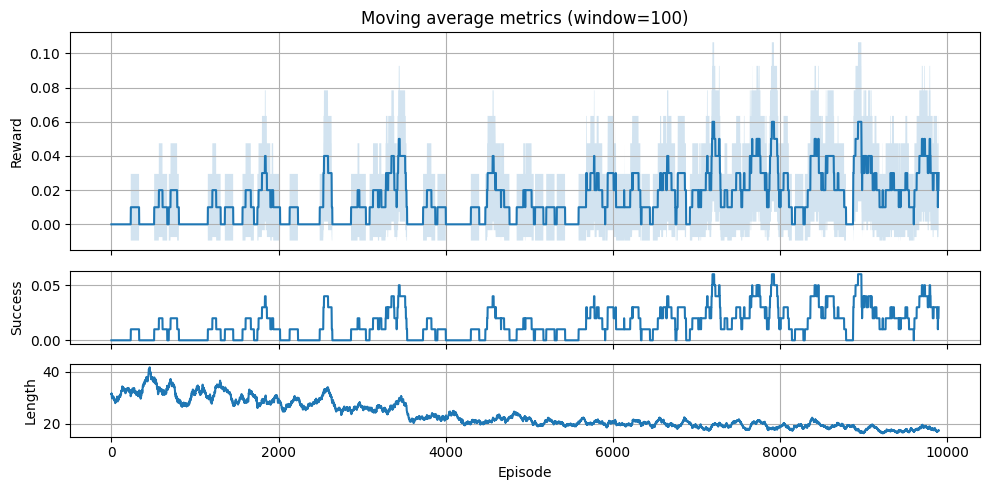

mean_reward,std_reward,ci_low,ci_high,n_total
1.000000,0.000000,1.000000,1.000000,90


Saved video to videos/qlearning_frozen_lake_8x8_non_slippery.mp4


In [86]:
run_experiment(
    exp_id="frozen_lake_8x8_non_slippery",
    env_id="FrozenLake-v1",
    env_kwargs={
        "map_name": "8x8",
        "is_slippery": False,
    },
    learning_kwards={
        "n_episodes": 10_000,
        "eps_start": 1.0,
        "eps_end": 0.5,
        "eps_decay": 0.0001,
        "max_steps": 200,
        "lr": 0.7,
        "gamma": 0.95,
    },
    success_fn=lambda reward, terminated, truncated, info: reward > 0,
)

### Frozen Lake: 8x8 slippery

  0%|          | 0/100000 [00:00<?, ?it/s]

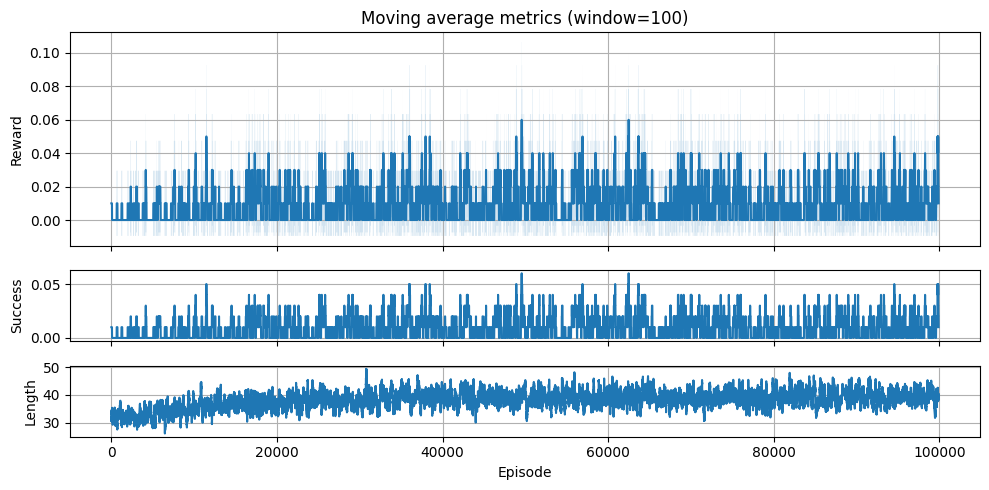

mean_reward,std_reward,ci_low,ci_high,n_total
0.044444,0.205480,0.001992,0.086897,90


Saved video to videos/qlearning_frozen_lake_8x8_slippery.mp4


In [88]:
run_experiment(
    exp_id="frozen_lake_8x8_slippery",
    env_id="FrozenLake-v1",
    env_kwargs={
        "map_name": "8x8",
        "is_slippery": True,
    },
    learning_kwards={
        "n_episodes": 100_000,
        "eps_start": 1.0,
        "eps_end": 0.5,
        "eps_decay": 0.0001,
        "max_steps": 200,
        "lr": 0.7,
        "gamma": 0.95,
    },
    success_fn=lambda reward, terminated, truncated, info: reward > 0,
)

### Environment: Taxi

TODO Describe environemnt https://gymnasium.farama.org/environments/toy_text/taxi/

In [45]:
# TODO Code to explore the environemnt

### Taxi: non-raining, non-fickle passenger

In [46]:
# TODO

### Taxi: raining, non-fickle passenger

In [47]:
# TODO

### Taxi: non-raining, fickle passenger

In [ ]:
# TODO

### Taxi: raining, fickle passenger

In [48]:
# TODO